In [7]:
import phoebe
import numpy as np
from phoebe import u
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: how to save?
import pickle

with open('test_single_sun.pickle', 'rb') as f:
    b = pickle.load(f)
    
from spectrum_nn import flux
import jax.numpy as jnp
import jax

from phoebe_utils import PhoebeConfig

In [8]:
from jax.config import config
config.update("jax_enable_x64", True)

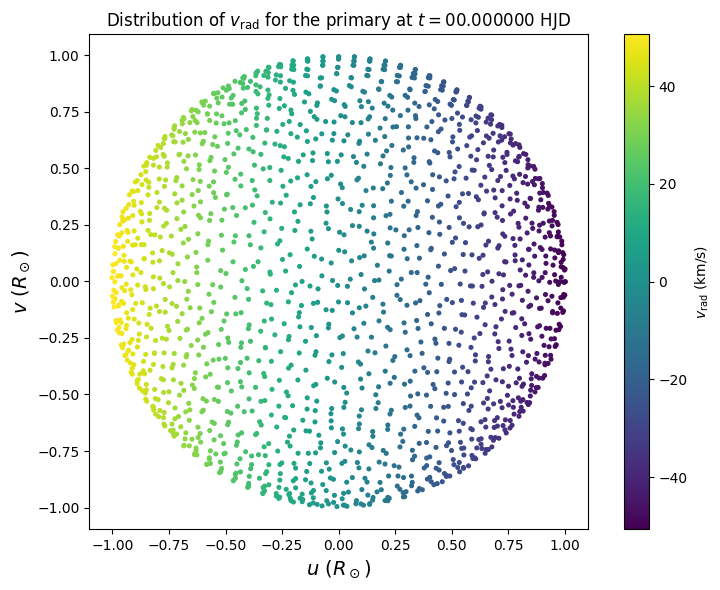

In [9]:
config = PhoebeConfig(b, 'mesh01')
time = config.times[0]

coords = config.get_mesh_coordinates(time)
VW = config.get_radial_velocities(time)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[:, 0], coords[:, 1], marker='o',c=VW,s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $v_{\rm rad}$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label=r'$v_{\rm rad}$ (km/s)')
plt.tight_layout()
plt.show()

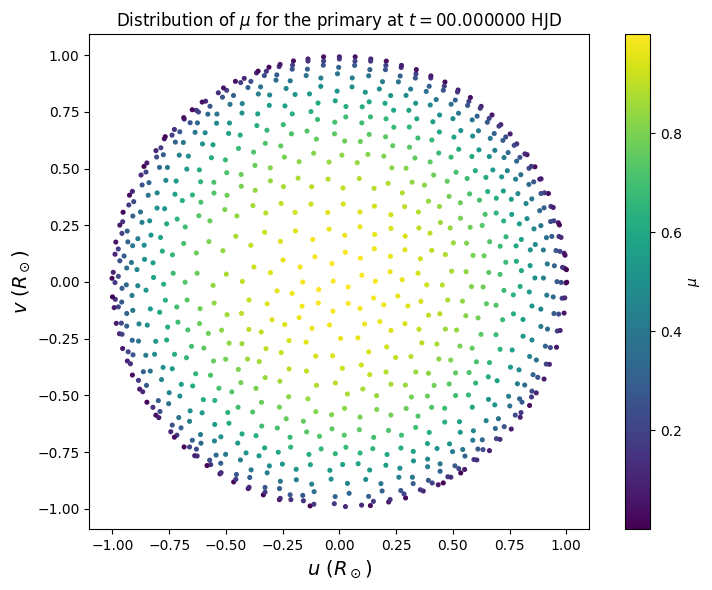

In [10]:
mus = config.get_mus(time)

pos_mus = np.argwhere(mus>0)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[pos_mus, 0], coords[pos_mus, 1], marker='o',c=mus[pos_mus],s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $\mu$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label='$\mu$')
plt.tight_layout()
plt.show()

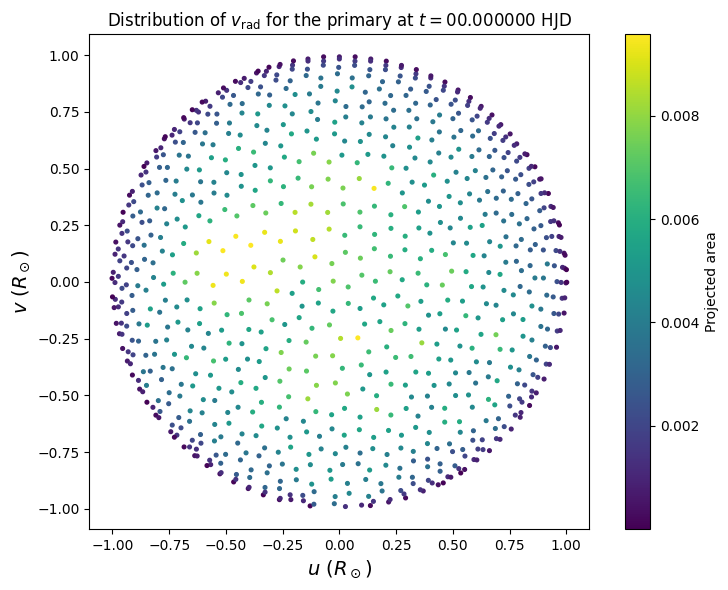

In [11]:
projected_areas = config.get_projected_areas(time)

pos_mus = np.argwhere(mus>0)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[pos_mus, 0], coords[pos_mus, 1], marker='o',c=projected_areas[pos_mus],s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $v_{\rm rad}$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label='Projected area')
plt.tight_layout()
plt.show()

In [12]:
np.sum(projected_areas[pos_mus])

3.134932233964279

In [13]:
mus = jnp.array(mus[pos_mus])
areas = jnp.array(projected_areas[pos_mus])

In [14]:
atmosphere_flux = jax.jit(jax.vmap(flux, in_axes=(None, 0)))

In [15]:
from functools import partial

In [16]:
CHUNK_SIZE = 1024
from jax import lax
import math

def _flash_sum(areas, mus, precision=100000):
    # Z każdym elementem powierzchni przekazujemy
    # wektor jego wartości (mu, przyspieszenie, itd.)
    # Część wartości będzie przekazywana do modelu
    
    # Just the 1D case for now
    n_areas, n_samples = areas.shape
    mus_flattened = mus.reshape(areas.shape)

    @partial(jax.checkpoint, prevent_cse=False)
    def chunk_scanner(carries, _):
        chunk_idx, atmo_sum = carries
        k_chunk_sizes = min(CHUNK_SIZE, n_areas)

        a_chunk = lax.dynamic_slice(areas,
                                    (chunk_idx, 0),
                                    (k_chunk_sizes, n_samples))
        m_chunk = lax.dynamic_slice(mus_flattened,
                                    (chunk_idx, 0),
                                    (k_chunk_sizes, n_samples))

        atmosphere_mul = jnp.multiply(
            a_chunk.reshape((-1, 1, 1)),
            atmosphere_flux(jnp.linspace(3.5, 3.8, precision),
                                jnp.ones_like(m_chunk).flatten()))

        new_atmo_sum = (jnp.sum(atmosphere_mul, axis=0)/jnp.sum(a_chunk, axis=0)).T
        return (chunk_idx + k_chunk_sizes, new_atmo_sum), None

    (_, out), lse = lax.scan(
        chunk_scanner,
        init=(0, jnp.zeros((precision, 2))),
        xs=None,
        length=math.ceil(n_areas/CHUNK_SIZE))
    return out

In [17]:
atmosphere = jnp.sum(
        atmosphere_flux(jnp.linspace(3.5, 3.8, 1000),
                        jnp.ones_like(mus).flatten()), axis=0)/len(mus.flatten())

In [18]:
# Gaussowskie prędkości na powierzchni gwiazdy- symulacja turbulencji

In [19]:
flash_atmosphere = _flash_sum(areas, mus, 10000)

In [20]:
# 10.000 - 658 ms
# 100.000 - 1.53 s
# 1.000.000 - 

In [21]:
jnp.ones_like(mus).flatten().shape

(855,)

In [22]:
a1 = flux(jnp.linspace(3.5, 3.8, 1000), 1.)

In [23]:
atmosphere.shape

(2, 1000)

In [24]:
# 3.5 trochę za h-alpha

In [25]:
flash_atmosphere.shape

(10000, 2)

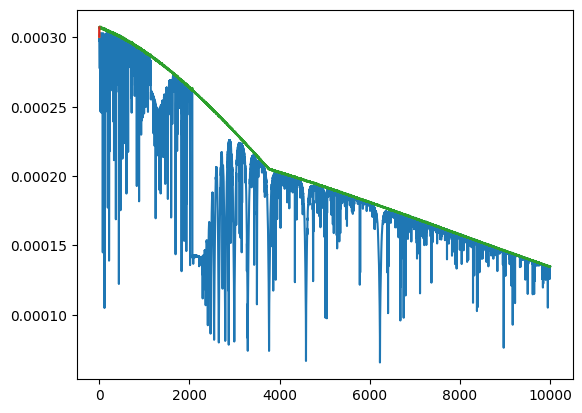

In [26]:
plt.plot(flash_atmosphere[:, 0]);
plt.plot(a1[:, 0])
plt.plot(flash_atmosphere[:, 1]);
plt.plot(a1[:, 1])

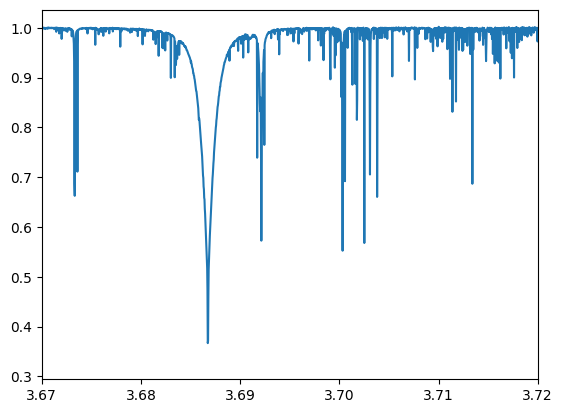

In [27]:
plt.plot(jnp.linspace(3.5, 3.8, 10000), flash_atmosphere[:, 0]/flash_atmosphere[:, 1]);
plt.gca().set_xlim(3.67, 3.72);